In this notebook we will be doing the following tasks:
1.   Define a small convolutional neural network and train in on MNIST digit dataset (as a classification task).
2.   Take the trained network, freeze all of its weights and learn the image which gives the output of a particular digit. (This will be defined better, when we reach that task).
3.   (Bonus) Try the same on a different dataset (like MNIST fashion dataset).
4.   (Bonus) Try to formulate the MNIST classification problem as a regression problem instead. (i.e. Have 1 output unit which outputs a floating point value and you round it off to obtain the digit.)










In [1]:

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Softmax


import numpy as np

from matplotlib import pyplot as plt

#This to ensure that the default device for processing PyTorch tensors is GPU instead of a CPU.
device = 'cuda' #Change this to 'cpu' to run on cpu. 

Here we will download the MNIST digit dataset and convert it into PyTorch dataset object. 

torchvision module of PyTorch provides several Computer Vision specific functionalities one of which is easy importing of several [popular datasets](https://pytorch.org/docs/stable/torchvision/datasets.html). 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


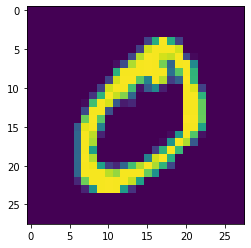

In [2]:
#We will load the MNIST dataset here.

#This creates a transform object which will be passed to the later functions. It converts the training image from PIL Image objects to PyTorch image objects.
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform )

test_data = torchvision.datasets.MNIST(root = './data',train = False ,download = True,  transform = transform)

 

print(train_data)
print(test_data)

plt.imshow(np.asarray(train_data[1][0].reshape(28,28)))



The following cell converts the DataSet objects to DataLoader objects. 
DataLoader objects in PyTorch provide several useful functionalities, such as automatic batching, parallel data processing on the CPU, etc. Therefore it is generally advisable to use dataloader instead of manually handling data. 

Read more about PyTorch DataSet and DataLoader [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [3]:
#BATCHs are only used for training, while testing we conventionally use a batch size of 1.  
BATCH_SIZE = 8
train_loader = torch.utils.data.DataLoader (train_data, batch_size = BATCH_SIZE )
test_loader = torch.utils.data.DataLoader (test_data, batch_size = 1 )




print(train_loader)

We will define our network in the following cell. There are several ways of doing this in PyTorch, but in this example we will do it by subclassing nn.module. You should be able to do this after reading the tutorials given at the top of the page. [This](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) is extra reading to help you out. (Do remember that we are dealing with 1 channel B/W images not 3 channels colour images.)

[Here](https://pytorch.org/docs/stable/nn.html) are official docs of nn module to help you out. 

Our network will have 4 convolutional layers followed by 2 fully-connected layers. (You free to change make slight changes to this but don't make the network too deep in the final submission). 

Don't forget to have ReLU activations and maxpooling layers.



In [4]:
class MyConvNet(nn.Module):
  def __init__(self):   
    super(MyConvNet, self).__init__()
    self.cnn_layers = Sequential(
            Conv2d(1,32 , kernel_size=3, stride=1,padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(32,64, kernel_size=3, stride=1,padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(64,128, kernel_size=3, stride=1,padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(128,256, kernel_size=3, stride=1,padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            
          
        )
      
    self.dense_layers = Sequential(
                                     Linear(256,10))
  
  def forward (self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.dense_layers(x)
    return F.softmax(x, dim = 1) 


The following cell will instantiate the the network we defined above.
Check the size of the output tensor (it should be [BATCH_SIZE, 10]) and see if the values in the output tensor printed below are numbers between 0 and 1. (Infact most values should be close to 0.1. Why?)

In [5]:
#Setting few things up.

net = MyConvNet()
net.to(device)
print(net)
tld = iter(train_loader)
im = next(tld)[0].to(device)
print ('Size of the output tensor:' ,net.forward(im).size())
print (net.forward(im))


MyConvNet(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
)
Size of the output tensor: torch.Size([8, 10])
tensor([[0.1021, 0.1036, 0.1023, 0.0990, 0.0955, 0.1009, 0.0960, 0.0943, 0.1050,
         0.1014],
        [0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The following cell will define the training and the testing loop. 





In [6]:
def train(model, train_loader, EPOCHS = 6, lossF = None):
  
  if lossF == None:
    lossF = nn.CrossEntropyLoss() #Cross entropy loss is popularly used for classification tasks. 
  
  ## Adam is a very popular choice of optimization algorithms. 
  ## It is not very sensitive to hyperparameters and therefore it becomes a natural choice in quick experiments.
  optim = torch.optim.Adam (model.parameters(), lr = 4e-4, weight_decay=1e-3) 
  
  model.train() #Changes the model to train mode. All the require_grad are set to true.
  
  for epoch in range(EPOCHS):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
      
      #Move data to device
      var_X_batch = Variable(X_batch).to(device) 
      var_y_batch = Variable(y_batch).to(device)
      # print(var_X_batch.size())
      
      ## Forward Pass!
      output = model(var_X_batch)

      # print(output)
      # print(output.size(), var_y_batch.size())
      
      ## Calculate the loss incurred
      loss = lossF (output, var_y_batch)
      
      ## BackProp: Computes all gradients.
      loss.backward()
      
      ## Gradient Descent Step (Adam)
      optim.step()
      optim.zero_grad() # This is important because PyTorch keeps on adding to the original value of gradient.

      ## Gets the predictions. From probablities (the digit with highest probablity is the prediction) 
      predicted = torch.max(output.data, axis = 1).indices
      
      # print(predicted)

      ## Calculates the number of correct predictions in a batch
      correct += (predicted == var_y_batch).sum()

      if (batch_idx % 200) == 0:
          print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))



def test(model, test_loader):
    
    correct = 0 
    for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
      var_X_batch = Variable(X_batch).to(device) 
      var_y_batch = Variable(y_batch).to(device)
      output = model(var_X_batch)
      predicted = torch.max(output.data, axis = 1).indices
      correct += (predicted == var_y_batch).sum()
      
    print("Test accuracy:{:.3f}% ".format( float(correct * 100) / (len(test_loader))))



Training the Network
 

In [7]:
train (net, train_loader, EPOCHS = 20)

Epoch : 0 [0/60000 (0%)]	Loss: 2.301817	 Accuracy:0.000%
Epoch : 0 [1600/60000 (3%)]	Loss: 1.807690	 Accuracy:35.137%
Epoch : 0 [3200/60000 (5%)]	Loss: 1.915731	 Accuracy:49.875%
Epoch : 0 [4800/60000 (8%)]	Loss: 1.704991	 Accuracy:57.072%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.494579	 Accuracy:63.702%
Epoch : 0 [8000/60000 (13%)]	Loss: 1.461441	 Accuracy:68.569%
Epoch : 0 [9600/60000 (16%)]	Loss: 1.595611	 Accuracy:72.044%
Epoch : 0 [11200/60000 (19%)]	Loss: 1.497170	 Accuracy:75.178%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.481507	 Accuracy:77.444%
Epoch : 0 [14400/60000 (24%)]	Loss: 1.490028	 Accuracy:79.157%
Epoch : 0 [16000/60000 (27%)]	Loss: 1.466298	 Accuracy:80.535%
Epoch : 0 [17600/60000 (29%)]	Loss: 1.582197	 Accuracy:81.798%
Epoch : 0 [19200/60000 (32%)]	Loss: 1.462526	 Accuracy:82.861%
Epoch : 0 [20800/60000 (35%)]	Loss: 1.461276	 Accuracy:83.727%
Epoch : 0 [22400/60000 (37%)]	Loss: 1.584705	 Accuracy:84.577%
Epoch : 0 [24000/60000 (40%)]	Loss: 1.477281	 Accuracy:85.297%
Epoch :

Running the test function defined above


In [8]:
test(net, test_loader)

Test accuracy:98.520% 


The following code is based on [this article](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) on Deep Dream.

We have trained our network to classify the numbers, but is there a way to know what exactly the network is searching for to classify them? In other words we would now like to tell the network to draw a number and see the output

We can do this by allowing the errors to be minimised by changing the input instead of the weights of the model. So the model is frozen and the input now is the Variable to optimize. The following loop is run

1. Initialize image tensor as im (maybe with all zeros).
2. Pass the image through the network.
3. Compute the loss with output of the net and expected output, say 7.
4. Run backpropogation upto the image tensor.
5. Update the image using the update rule. (Specified by torch.optim object)

In [9]:
def train_im(model, train_loader, digit = 7 ,iters = 1000, lossF = None):
  """
  Train the input image to match the <digit>. Run <iters> iterations of Gradient Descent.  
  """
  im = torch.zeros_like(train_data[1][0]).view(1, 1, 28, 28).to(device)
  im = Variable(im, requires_grad = True)
  digit = Variable(torch.tensor(digit)).to(device).view(1)

  if lossF == None:
    lossF = nn.CrossEntropyLoss() #Cross entropy loss is popularly used for classification tasks. 
  
  optim = torch.optim.Adam ([im,], lr = 1e-3) 
  
  # Put your code here: 
  # __begin
  for epoch in range(iters):
      output = model(im)

      # print(output)
      # print(output.size(), var_y_batch.size())
      
      ## Calculate the loss incurred
      loss = lossF (output, digit)
      
      ## BackProp: Computes all gradients.
      loss.backward()
      
      ## Gradient Descent Step (Adam)
      optim.step()
      optim.zero_grad() # This is important because PyTorch keeps on adding to the original value of gradient.

  
  #__end
    
  return im

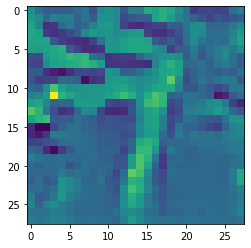

In [10]:
## Let's run our function for 7 and see what image we get.

im = train_im (net, train_loader, digit=7,iters=10000)
im = np.asarray(im.view(28, 28).cpu().detach())
plt.imshow(im)

In the the following cell we will run the function for all the digits from 0 to 9 and print the outputs! 


0


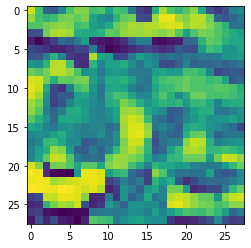

1


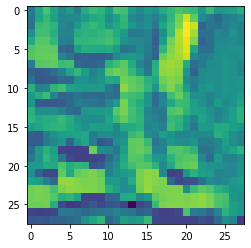

2


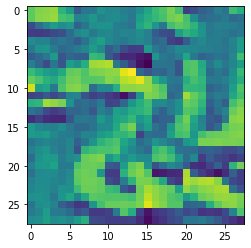

3


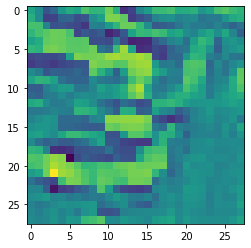

4


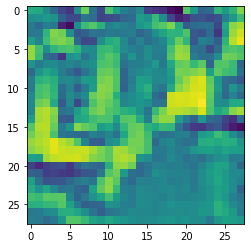

5


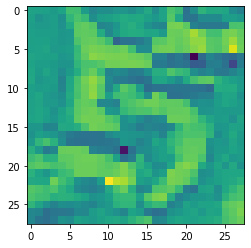

6


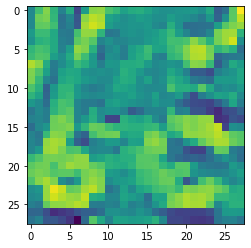

7


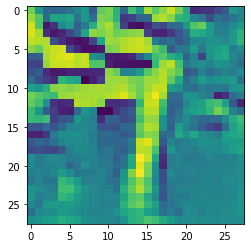

8


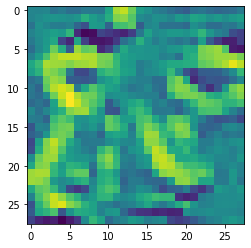

9


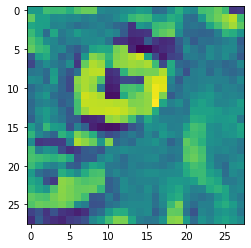

In [11]:
for i in range (10):
  im = train_im (net, train_loader, digit=i, iters=1000)
  im = np.asarray(im.view(28, 28).cpu().detach())
  print (i)
  plt.imshow(im)
  plt.show()